# Kitchenware Classifier

In [1]:
import gc
import os
import sys

from collections import defaultdict
from hashlib import md5

import numpy as np
import PIL
import seaborn as sns
import fastai
import torch

from fastai.vision.all import *
from torch import device

print(os.listdir('kitchenware_classifier/data/'))
print('Python       :', sys.version.split("\n")[0])
print('FastAI       :', fastai.__version__)
print('Numpy        :', np.__version__)
print('Torch        :', torch.__version__)
print('CUDA         :', torch.cuda.is_available())

%matplotlib inline

['sample_submission.csv', 'test.csv', 'models', 'train.csv', 'images']
Python       : 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]
FastAI       : 2.7.10
Numpy        : 1.23.5
Torch        : 1.13.1+cu117
CUDA         : True


## Load data and set variables

In [2]:
SEED = 42
set_seed(42)

PROJECT_DIR = Path('kitchenware_classifier')
DATA_DIR = PROJECT_DIR / 'data'
IMG_DIR = DATA_DIR / 'images'

TRAIN_DF = pd.read_csv(DATA_DIR / 'train.csv')
TEST_DF = pd.read_csv(DATA_DIR / 'test.csv')
TRAIN_DF['image'] = TRAIN_DF['Id'].map(lambda x: f'{x:0>4}.jpg')
TEST_DF['image'] = TEST_DF['Id'].map(lambda x: f'{IMG_DIR}/{x:0>4}.jpg')

In [3]:
display(TRAIN_DF.head())
display(TEST_DF.head())

,Id,label,image
0,560,glass,0560.jpg
1,4675,cup,4675.jpg
2,875,glass,0875.jpg
3,4436,spoon,4436.jpg
4,8265,plate,8265.jpg


,Id,image
0,678,kitchenware_classifier/data/images/0678.jpg
1,3962,kitchenware_classifier/data/images/3962.jpg
2,9271,kitchenware_classifier/data/images/9271.jpg
3,5133,kitchenware_classifier/data/images/5133.jpg
4,8842,kitchenware_classifier/data/images/8842.jpg


## EDA

In [4]:
TRAIN_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5559 entries, 0 to 5558
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      5559 non-null   int64 
 1   label   5559 non-null   object
 2   image   5559 non-null   object
dtypes: int64(1), object(2)
memory usage: 130.4+ KB


### Check the class distributions

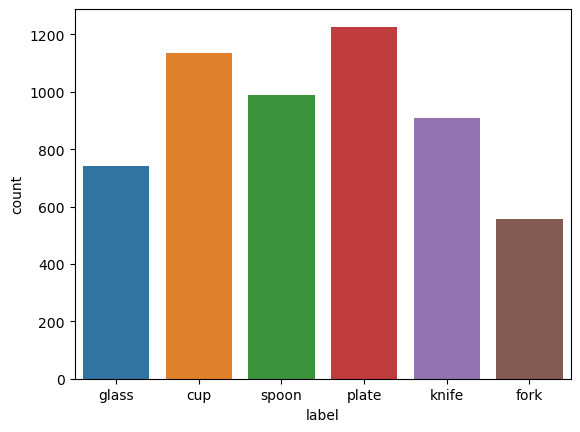

In [5]:
sns.countplot(data=TRAIN_DF, x='label')
plt.show()

### Check for duplicate images

In [6]:
hash_dict = defaultdict(list)
for image in IMG_DIR.glob('*.jpg'):
    with image.open('rb') as f:
        img_hash = md5(f.read()).hexdigest()
        hash_dict[img_hash].append(image)
len(hash_dict)

9361

In [7]:
duplicate_img = []
for k, v in hash_dict.items():
    if len(v) > 1:
        if v[0].name != v[1].name:
            duplicate_img.append(v[0])
            duplicate_img.append(v[1])
            print(v)
len(duplicate_img)

[Path('kitchenware_classifier/data/images/7103.jpg'), Path('kitchenware_classifier/data/images/5428.jpg')]
[Path('kitchenware_classifier/data/images/4234.jpg'), Path('kitchenware_classifier/data/images/0237.jpg')]
[Path('kitchenware_classifier/data/images/4162.jpg'), Path('kitchenware_classifier/data/images/3458.jpg')]
[Path('kitchenware_classifier/data/images/8532.jpg'), Path('kitchenware_classifier/data/images/6833.jpg')]
[Path('kitchenware_classifier/data/images/7196.jpg'), Path('kitchenware_classifier/data/images/7063.jpg')]
[Path('kitchenware_classifier/data/images/6624.jpg'), Path('kitchenware_classifier/data/images/7469.jpg')]


12

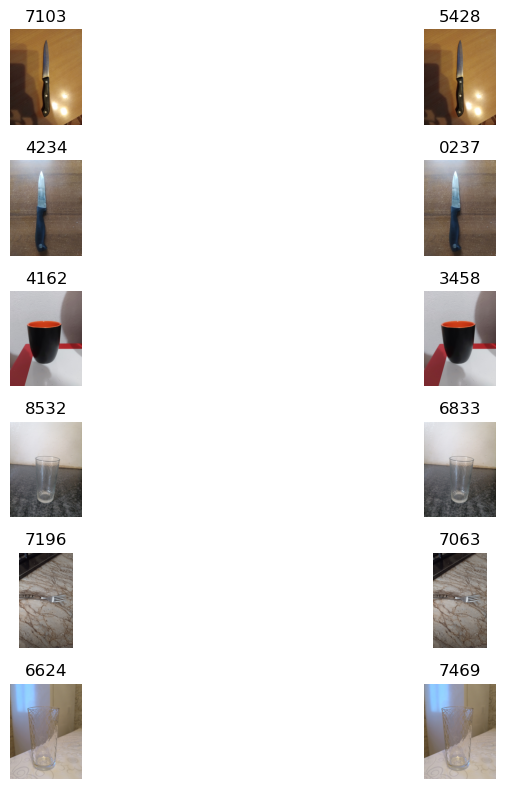

In [8]:
plt.figure(figsize=(12,8))

for idx, img in enumerate(duplicate_img):
    im = PIL.Image.open(img)
    title = img.stem
    plt.subplot(6,2, idx+1)
    plt.imshow(im)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
(len(duplicate_img) / len(hash_dict))

0.0012819143253925862

> Since the amount of duplicate images are so insignificant, I'm not going to worry about them.

## Data Augmentations

In [10]:
tfms = aug_transforms(
    min_zoom=1.0,
    max_zoom=1.1,
    max_lighting=0.2,
    max_warp=0.2,
    p_affine=0.75,
    p_lighting=0.75,
    size=224,
)

## Build data loaders

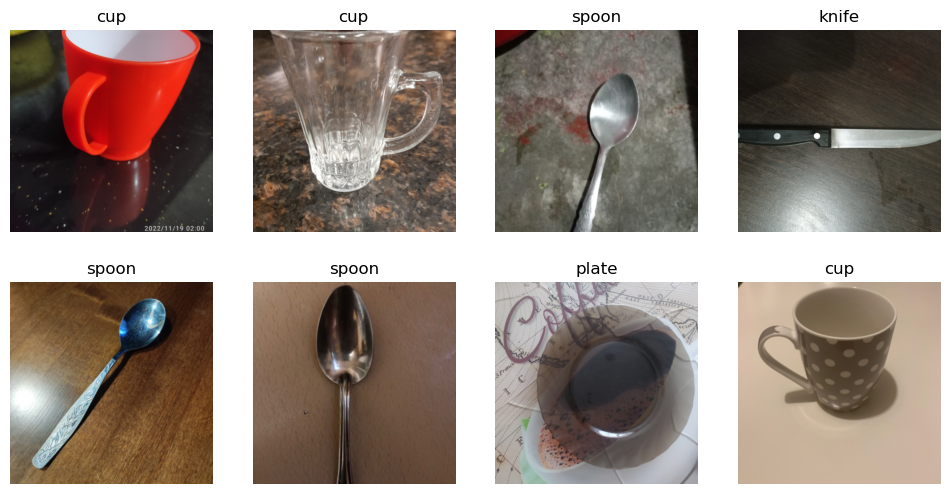

In [11]:
dls = ImageDataLoaders.from_df(
    TRAIN_DF,
    path=str(IMG_DIR),
    valid_pct=0.2,
    seed=42,
    bs=8,
    val_bs=8,
    fn_col='image',
    shuffle=True,
    label_col='label',
    item_tfms=Resize(460),
    batch_ftms=list(tfms),
    device=device('cuda'),
)
dls.show_batch()

## Build learner

In [12]:
def build_learner(model):
    learn = vision_learner(
        dls,
        model,
        metrics=[error_rate, accuracy],
        path=".",
    )
    keep_path = learn.path
    learn.path = DATA_DIR

    print(f"[{model}] Finding best learning rate...")
    lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
    print(f"{lrs=}")

    save_best = SaveModelCallback(
        monitor="valid_loss",
        min_delta=0.000001,
        fname=f"{model}-best_model",
    )
    early_stop = EarlyStoppingCallback(
        monitor="valid_loss",
        min_delta=0.000001,
        patience=3,
    )

    print(f"[{model}] Training the Model...")
    learn.fit(10, lrs.valley, cbs=[save_best, early_stop])
    learn.path = keep_path
    
    return learn

[convnext_nano] Finding best learning rate...


lrs=SuggestedLRs(minimum=0.006918309628963471, steep=9.12010818865383e-07, valley=0.0014454397605732083, slide=0.002511886414140463)
[convnext_nano] Training the Model...


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.438907,0.136298,0.035104,0.964897,02:05
1,0.315311,0.117659,0.037804,0.962196,02:06
2,0.317094,0.101979,0.035104,0.964897,02:06
3,0.250049,0.115627,0.040504,0.959496,02:06
4,0.175600,0.090287,0.025203,0.974797,02:06
5,0.197798,0.091826,0.028803,0.971197,02:06
6,0.224085,0.102250,0.039604,0.960396,02:08
7,0.195272,0.091467,0.027903,0.972097,02:06


Better model found at epoch 0 with valid_loss value: 0.13629820942878723.
Better model found at epoch 1 with valid_loss value: 0.11765861511230469.
Better model found at epoch 2 with valid_loss value: 0.10197863727807999.
Better model found at epoch 4 with valid_loss value: 0.09028682112693787.
No improvement since epoch 4: early stopping


[resnet50] Finding best learning rate...


lrs=SuggestedLRs(minimum=0.010000000149011612, steep=7.585775847473997e-07, valley=0.0020892962347716093, slide=0.0010000000474974513)
[resnet50] Training the Model...


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.695708,0.505436,0.103510,0.896490,02:04
1,0.542038,0.231417,0.067507,0.932493,02:04
2,0.410965,0.223523,0.063006,0.936994,02:04
3,0.393910,0.130503,0.045005,0.954996,02:04
4,0.397882,0.136125,0.041404,0.958596,02:04
5,0.333754,0.142681,0.049505,0.950495,02:04
6,0.237715,0.139498,0.040504,0.959496,02:04


Better model found at epoch 0 with valid_loss value: 0.5054362416267395.
Better model found at epoch 1 with valid_loss value: 0.23141688108444214.
Better model found at epoch 2 with valid_loss value: 0.22352270781993866.
Better model found at epoch 3 with valid_loss value: 0.13050289452075958.
No improvement since epoch 3: early stopping


[xception] Finding best learning rate...


lrs=SuggestedLRs(minimum=0.003981071710586548, steep=0.0006918309954926372, valley=0.0006918309954926372, slide=0.001737800776027143)
[xception] Training the Model...


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.522578,0.119343,0.045905,0.954095,02:53
1,0.321258,0.125595,0.043204,0.956796,02:53
2,0.175673,0.097279,0.029703,0.970297,02:53
3,0.208865,0.094577,0.027003,0.972997,02:53
4,0.157138,0.117275,0.034203,0.965797,02:53
5,0.204342,0.098270,0.031503,0.968497,02:53
6,0.182505,0.101564,0.036004,0.963996,02:53


Better model found at epoch 0 with valid_loss value: 0.11934325844049454.
Better model found at epoch 2 with valid_loss value: 0.09727930277585983.
Better model found at epoch 3 with valid_loss value: 0.09457682073116302.
No improvement since epoch 3: early stopping


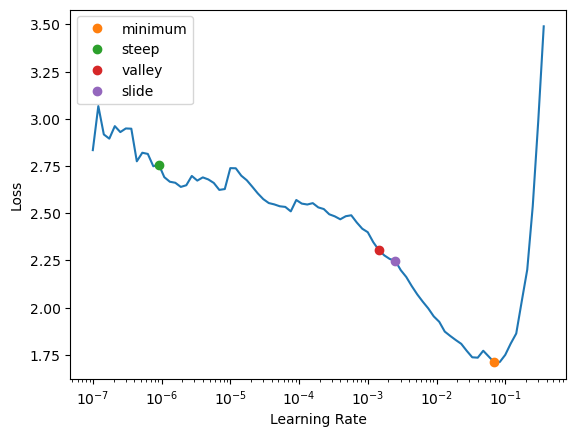

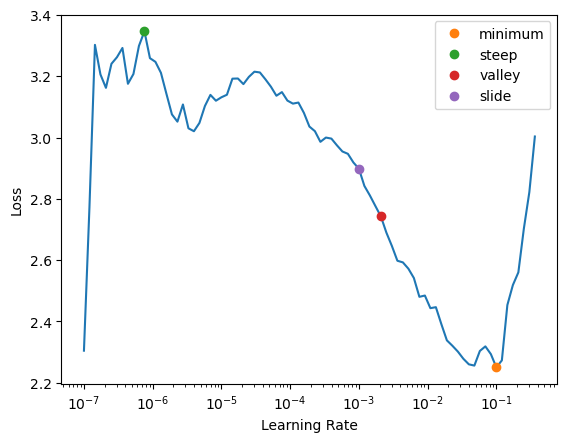

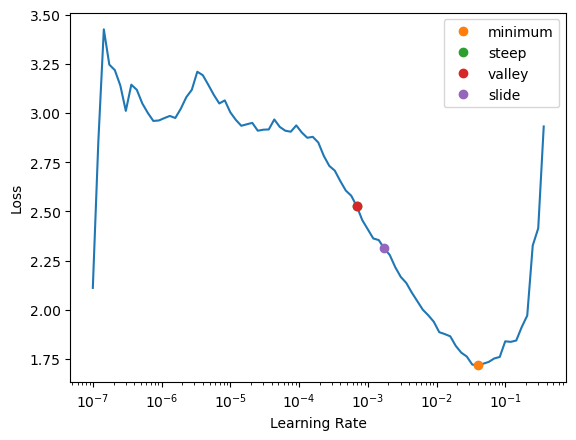

In [13]:
models = ['convnext_nano', 'resnet50', 'xception']
model_metrics = pd.DataFrame(
    columns=['model', 'valid_loss', 'error_rate', 'accuracy', 'minimum', 'steep', 'valley', 'slide', 'learner'])
for model in models:
    learner = build_learner(model)
    val, err, acc = learner.validate()
    model_metrics.loc[len(model_metrics.index)] = [model, val, err, acc, minimum, steep, valley, slide, learner]
    learn = None
    gc.collect()
    torch.cuda.empty_cache()

In [14]:
model_metrics[['model', 'valid_loss', 'error_rate', 'accuracy']]

,model,valid_loss,error_rate,accuracy
0,convnext_nano,0.090287,0.025203,0.974797
1,resnet50,0.130503,0.045005,0.954996
2,xception,0.094577,0.027003,0.972997


In [15]:
best_model = model_metrics.loc[model_metrics['accuracy'] == model_metrics.accuracy.max()]
best_model.model

0    convnext_nano
Name: model, dtype: object

In [16]:
learn = best_model.learner.iloc[0]
learn

## Save the model

In [17]:
learn.export(f'kitchenware_{best_model.model.iloc[0]}.pkl')

## Evaluate results

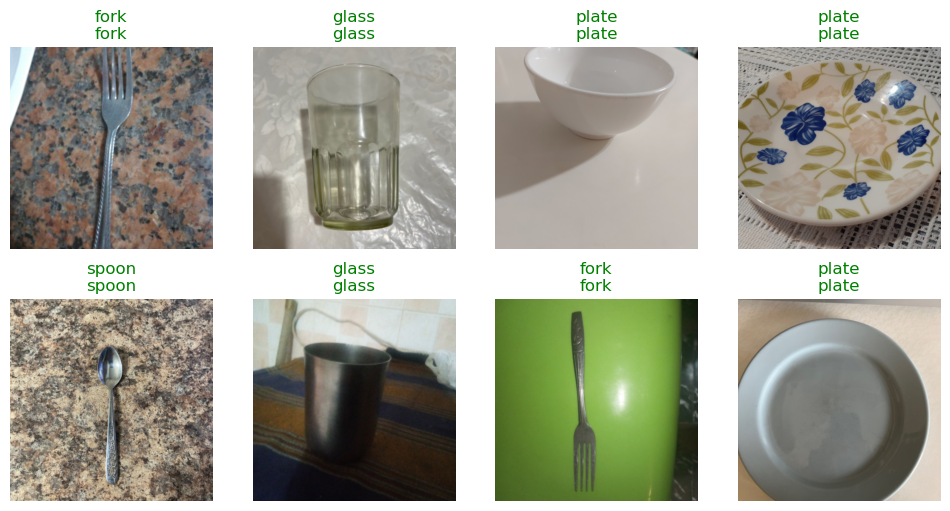

In [18]:
learn.show_results()

In [19]:
interp = Interpretation.from_learner(learn)

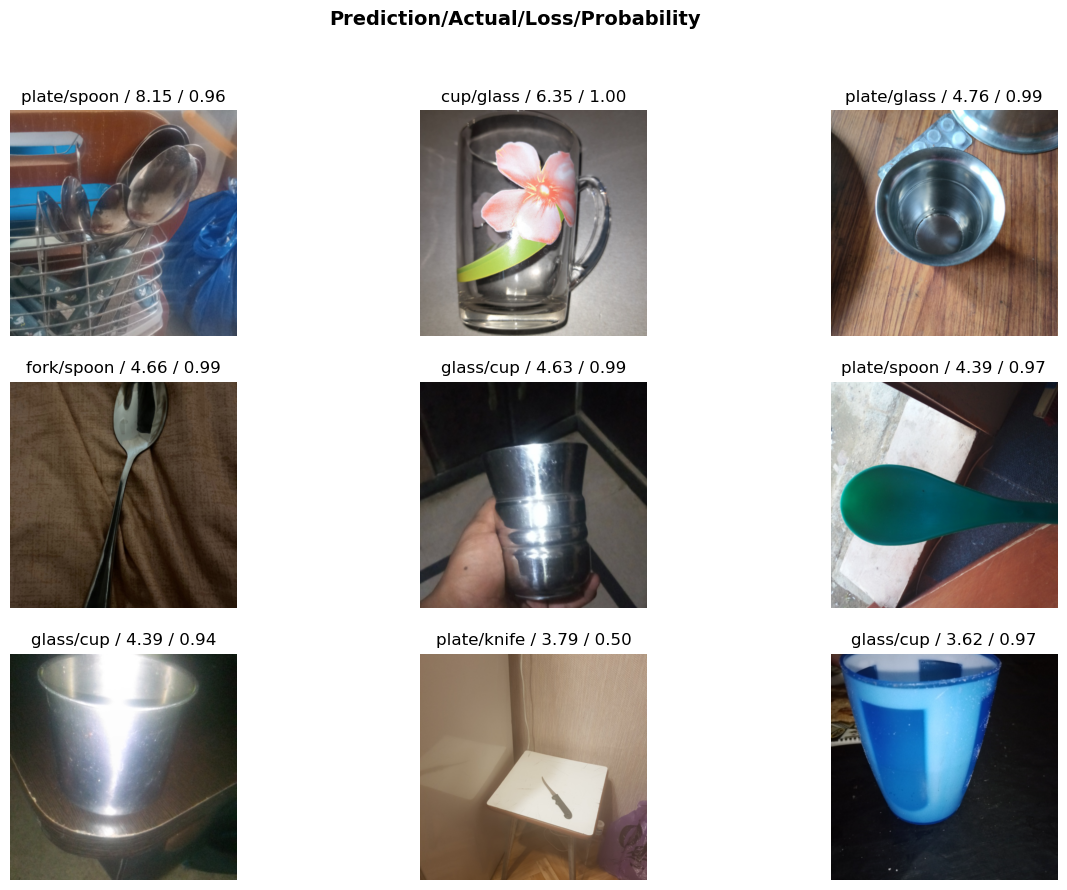

In [20]:
interp.plot_top_losses(9, figsize=(15, 10))

## Predict on testset using (TTA) Test Time Augmentation

In [21]:
tst_dl = dls.test_dl(TEST_DF.image)
tta = learn.tta(dl=tst_dl)

## Create submission file

In [22]:
tta_preds, _ = tta
idxs = tta_preds.argmax(dim=1)
vocab = np.array(dls.vocab)
sub = pd.read_csv(DATA_DIR /'test.csv')
sub['label'] = vocab[idxs]
sub.to_csv('submission.csv', index=False)
sub.head()

,Id,label
0,678,spoon
1,3962,knife
2,9271,fork
3,5133,plate
4,8842,fork


In [23]:
learn.summary()

Sequential (Input shape: 8 x 3 x 460 x 460)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 80 x 115 x 115  
Conv2d                                    3920       False     
LayerNorm2d                               160        True      
Identity                                                       
Conv2d                                    4000       False     
LayerNorm2d                               160        True      
____________________________________________________________________________
                     8 x 320 x 115 x 115 
Conv2d                                    25920      False     
Identity                                                       
GELU                                                           
Dropout                                                        
____________________________________________________________________________
                     8 x 80 x 115 x 115  
Conv2d                              